<a href="https://colab.research.google.com/github/intelligenxe/gym-anytrading-RL/blob/main/STOCKS_GYM_ANYTRADING_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on https://www.youtube.com/watch?v=LXz7__lHn8k&t=129s
It has been modified to run for STOCKS (as opposed to FOREX) and this version runs with no bugs

### Installs & Imports

In [48]:
pip install gym-anytrading stable_baselines3

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C

#import quantstats as qs

## Data Wrangle

In [50]:
from gym_anytrading.datasets import STOCKS_GOOGL

df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


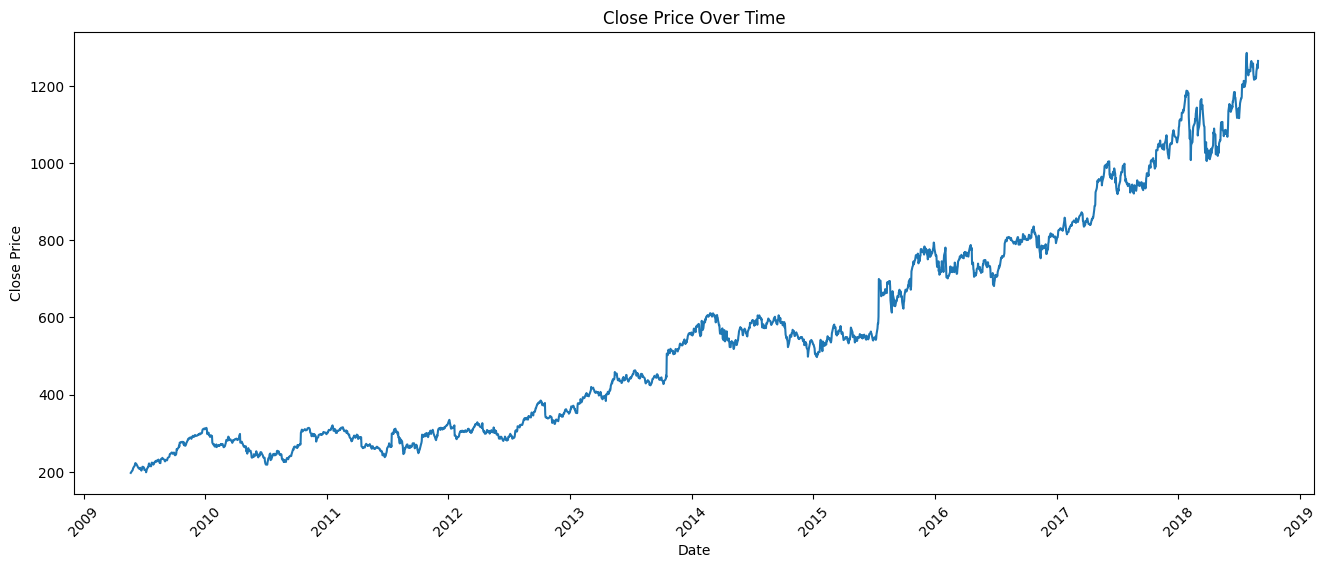

In [51]:


plt.figure(figsize=(16, 6))  # Set figure size before plotting

# Assuming 'df' has a DatetimeIndex, use df.index for the x-axis
plt.plot(df.index, df['Close'])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the graph
plt.show()

In [52]:
'''
import yfinance as yf

stock = yf.Ticker("TQQQ")

# raw = stock.info
raw = stock.history(period="max")
raw
'''

'\nimport yfinance as yf\n\nstock = yf.Ticker("TQQQ")\n\n# raw = stock.info\nraw = stock.history(period="max")\nraw\n'

## Make Environment

In [53]:
window_size = 10
start_index = window_size
#  end_index = len(df)
end_index = int(len(df)/8)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


## Explore Environment

action_stats: {<Actions.Sell: 0>: 165, <Actions.Buy: 1>: 126}
info: {'total_reward': 4.7397613525390625, 'total_profit': 0.35251684996017046, 'position': <Positions.Long: 1>}


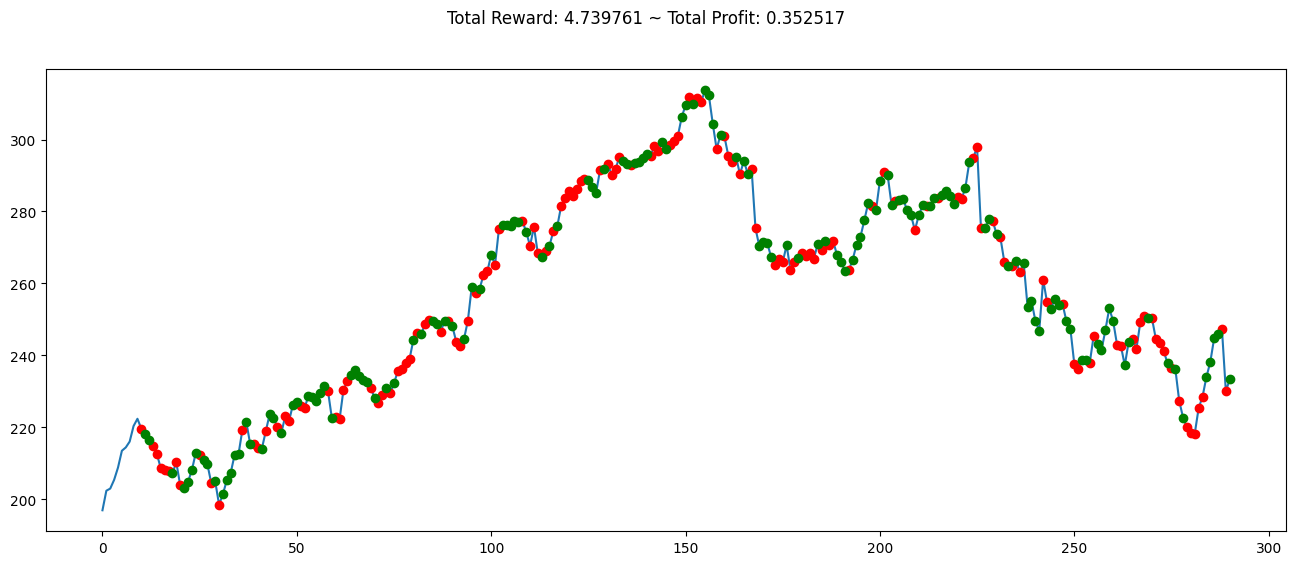

In [54]:
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break
print("action_stats:", action_stats)
print("info:", info)

plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

## Train Agent

In [55]:
env.reset()
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 280      |
|    ep_rew_mean        | 32.9     |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 10.6     |
|    value_loss         | 240      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 280      |
|    ep_rew_mean        | 16.1     |
| time/                 |          |
|    fps                | 106      |
|    iterations         | 200      |
|    time_elapsed 

## Test/Evaluate Agent

action_stats: {<Actions.Sell: 0>: 123, <Actions.Buy: 1>: 157}
info: {'total_reward': 26.481475830078125, 'total_profit': 0.3562948459521432, 'position': <Positions.Long: 1>}


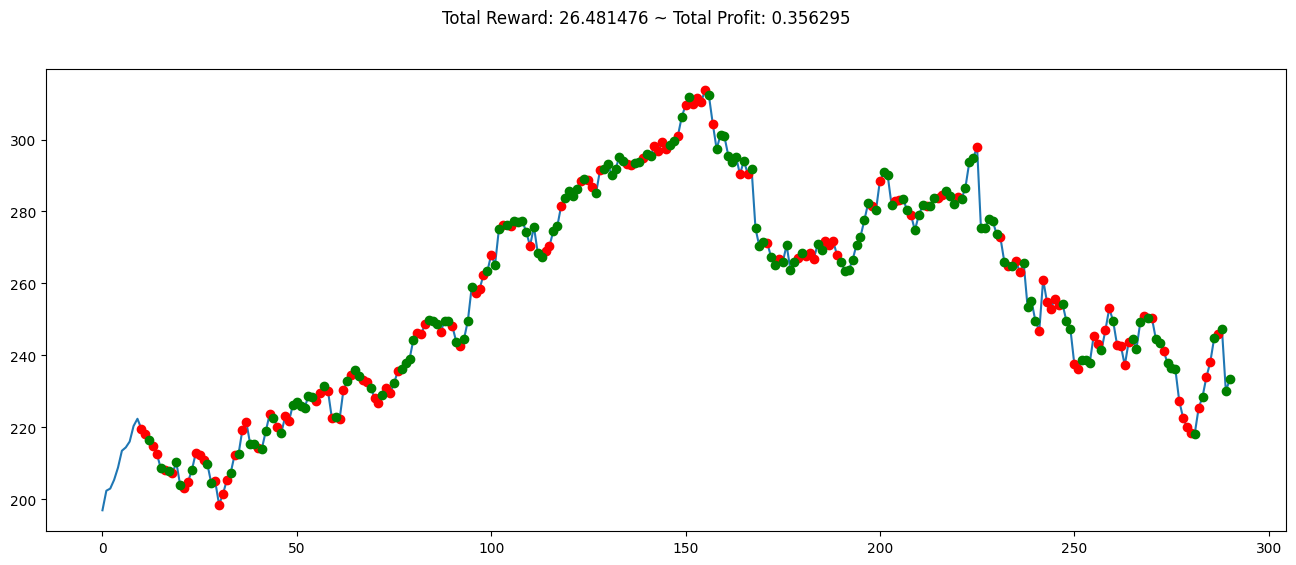

In [56]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset()

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break
print("action_stats:", action_stats)
print("info:", info)
env.close()

plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()



---



---
# Using Trained Model in a NEW (simulted future) Environment


## Make NEW Environment

In [57]:
window_size = 10
start_index = int(len(df)*1/8)
#  end_index = len(df)
end_index = int(len(df)*3/16)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


## Explore NEW Environment

action_stats: {<Actions.Sell: 0>: 123, <Actions.Buy: 1>: 157}
info: {'total_reward': 44.68464660644531, 'total_profit': 0.6567964370604905, 'position': <Positions.Long: 1>}


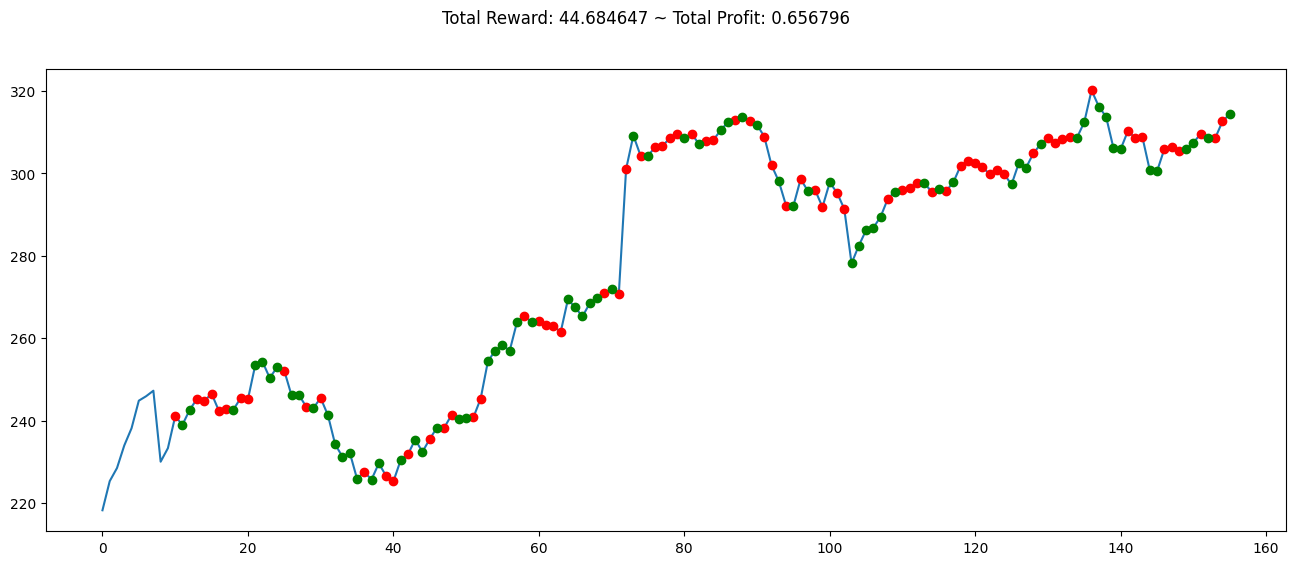

In [58]:
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break
print("action_stats:", action_stats)
print("info:", info)

plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

## Test/Evaluate Agent in NEW Environment

action_stats: {<Actions.Sell: 0>: 67, <Actions.Buy: 1>: 78}
info: {'total_reward': 38.69378662109375, 'total_profit': 0.6813731311144641, 'position': <Positions.Long: 1>}


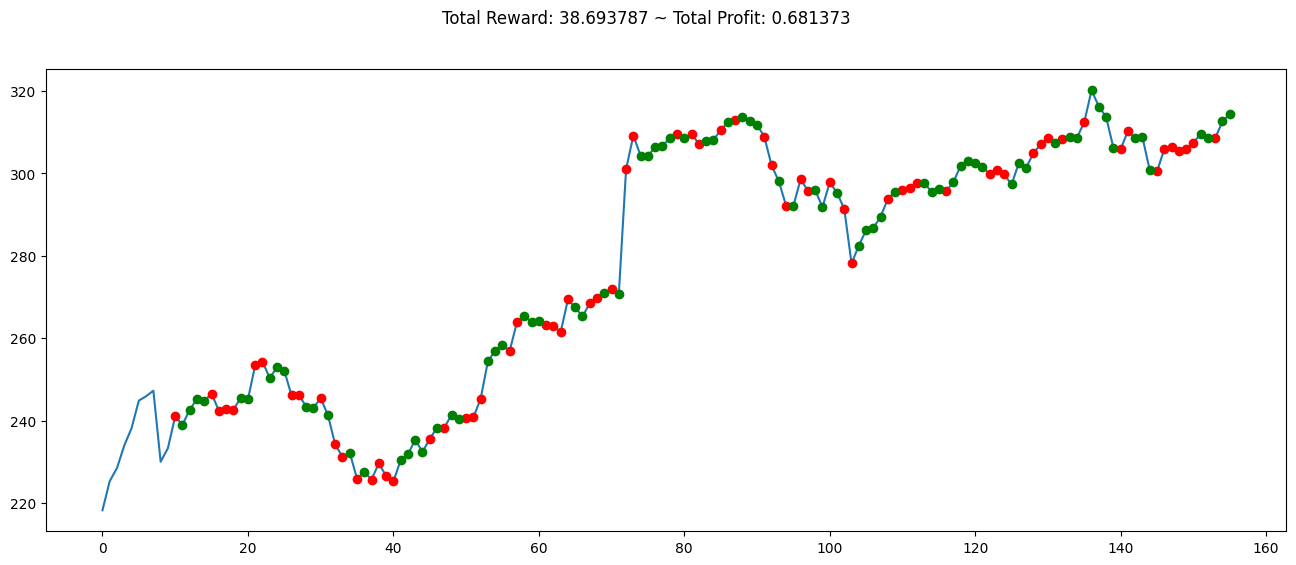

In [59]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset()

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()